In [ ]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()
b = phoebe.default_binary()
times = np.linspace(0, 100, 100)
COLUMNS = ['us', 'vs', 'ws',
                                            'vus', 'vvs', 'vws',
                                            'nus', 'nvs', 'nws',
                                            'areas', 'loggs', 'teffs', 'rprojs',
                                            'mus', 'visibilities', 'visible_centroids', 'rs']
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none')

Wed, 31 May 2023 15:20 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.
100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


In [74]:
import jax.numpy as jnp
import jax
from functools import partial

In [15]:
def get_primary_comp(time, qualifier):
    return b.get_parameter(qualifier=qualifier,
                           component='primary',
                           dataset='mesh01',
                           kind='mesh',
                           time=time).value

def get_secondary_comp(time, qualifier):
    return b.get_parameter(qualifier=qualifier,
                           component='secondary',
                           dataset='mesh01',
                           kind='mesh',
                           time=time).value

In [79]:
coords = get_coords()

In [80]:
def params(qualifier):
    return jnp.concatenate([jnp.array([get_primary_comp(time, qualifier) for time in times]),
                            jnp.array([get_secondary_comp(time, qualifier) for time in times])])

In [71]:
primary_rprojs = jnp.array([get_primary_comp(time, 'rprojs') for time in times])
primary_areas = jnp.array([get_primary_comp(time, 'areas') for time in times])

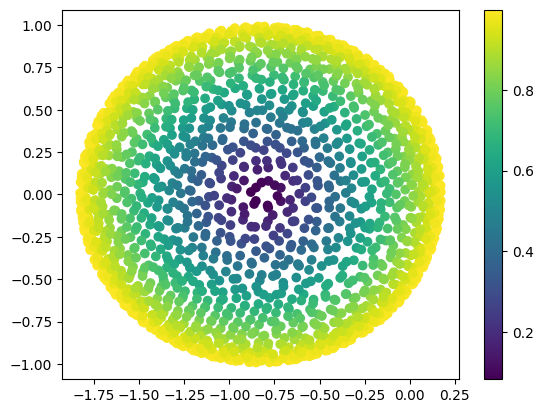

In [70]:
plt.scatter(coords_primary[5, 0], coords_primary[5, 1], c=primary_rprojs[5])
plt.colorbar()

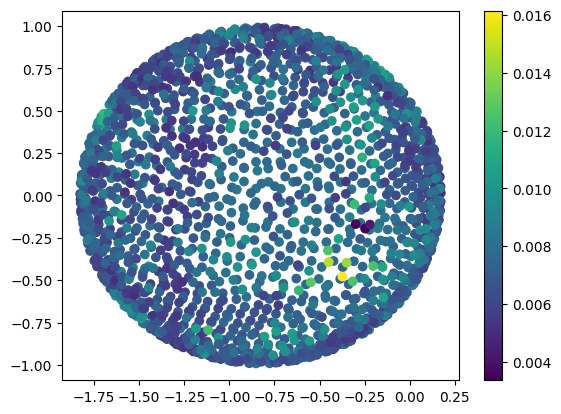

In [72]:
plt.scatter(coords_primary[5, 0], coords_primary[5, 1], c=primary_areas[5])
plt.colorbar()

In [41]:
%matplotlib inline

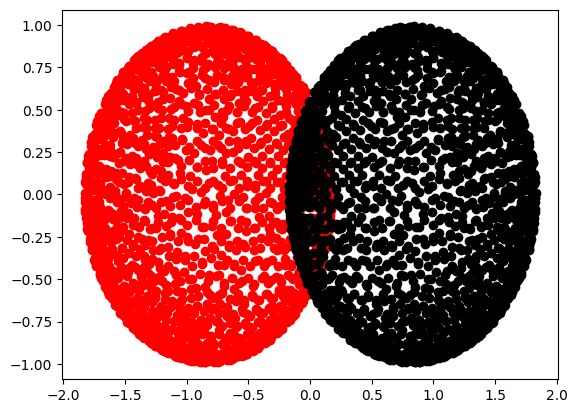

In [50]:
plt.scatter(coords_primary[5, 0], coords_primary[5, 1], color='red')
plt.scatter(coords_secondary[5, 0], coords_secondary[5, 1], color='black')

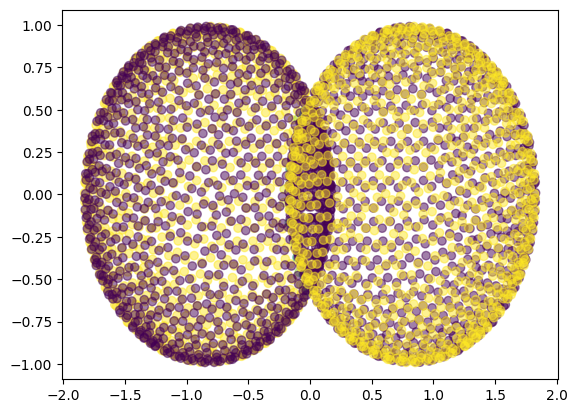

In [107]:
plt.scatter(coords_primary[5, 0], coords_primary[5, 1], c=primary_visibilities[5], alpha=0.5)
plt.scatter(coords_secondary[5, 0], coords_secondary[5, 1], c=secondary_visibilities[5], alpha=0.5)

In [104]:
primary_vels = jnp.array([get_primary_comp(time, 'vus') for time in times])
secondary_vels = jnp.array([get_secondary_comp(time, 'vus') for time in times])

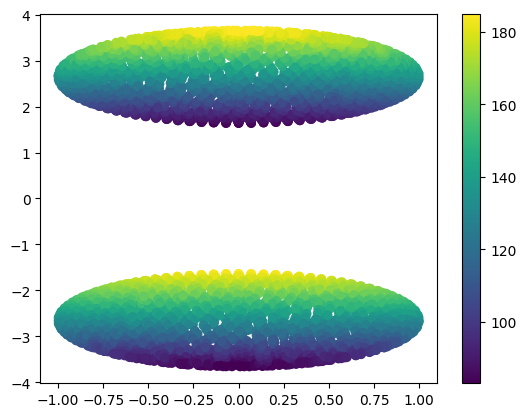

In [108]:
time = 0
plt.scatter(coords_primary[time, 0], coords_primary[time, 2], c=primary_vels[time])
plt.scatter(coords_secondary[time, 0], coords_secondary[time, 2], c=secondary_vels[time])
plt.colorbar()

In [82]:
@partial(jax.jit, static_argnums=(9,))
def model_spectrum(teffs, loggs, mus, vturb, visibilites, abundances, areas, vels,
                   log_wavelengths: jnp.ndarray, chunk_size: int = 256):
    mus = visibilities*jnp.where(mus>0, mus, 0.)
    parameters = jnp.concatenate([_teffs,
                                  loggs,
                                  jnp.ones_like(teffs)*vturb,
                                  abundances],
                                  axis=1)
    return spectrum_flash_sum(log_wavelengths,
                              (mus*areas)[:, jnp.newaxis],
                              mus,
                              vels,
                              parameters,
                              chunk_size)

In [94]:
teffs = params('teffs')
loggs = params('loggs')
vturb = 1.
visibilities = params('rprojs')
areas = params('areas')
abundances = jnp.array([*jnp.ones(16)*0.1, 0.5])
abundances = jnp.repeat(abundances.reshape((1, -1)), areas.shape[0], axis=0)
vels = 